In [5]:
import pandas as pd
import numpy as np
import preprocessing as pp

#Importacion arboles
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier

#Importacion preprocesamiento
from sklearn.model_selection import train_test_split

#Importacion metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#Librerias para visualizacion
import seaborn as sb
import matplotlib.pyplot as plt

In [6]:
def getData():
  return pd.read_csv("https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv&gid=2054774482")

def getDataTestFinal():
  return pd.read_csv("https://docs.google.com/spreadsheets/d/1ObsojtXfzvwicsFieGINPx500oGbUoaVTERTc69pzxE")

In [7]:
df = getData()
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


In [8]:
df_edit = pd.DataFrame()
df_edit = df.copy()

X, y, df_new, y_encoder = pp.feature_engineering_xg_rf(df_edit)
df_new.head()

,tiene_alto_valor_adquisitivo,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [9]:
print("Cantidad de features en el nuevo set")
print(len(df_new.columns))

Cantidad de features en el nuevo set
47


In [10]:
# Obtengo los sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [11]:
# n_estimators es el numero de arboles
classifier=RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0)

# Entrenar
classifier.fit(X_train, y_train)

# Predecir
predictions=classifier.predict(X_test)

In [12]:
# Obtener metricas de error
print("Matriz de confusion")
print(confusion_matrix(y_test, predictions))
print("\n")

print("Porcentaje de aciertos")
print(round(accuracy_score(y_test, predictions),3))
print("\n")

print("Precision")
print(round(precision_score(y_test, predictions),3))
print("\n")

print("Recall")
print(round(recall_score(y_test, predictions),3))
print("\n")

print("F1 Score")
print(round(f1_score(y_test, predictions),3))

Matriz de confusion
[[4785  157]
 [1038  533]]


Porcentaje de aciertos
0.817


Precision
0.772


Recall
0.339


F1 Score
0.471


# Analisis de features de random forest

In [13]:
def plot_roc(_fpr, _tpr, x):
    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(_fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

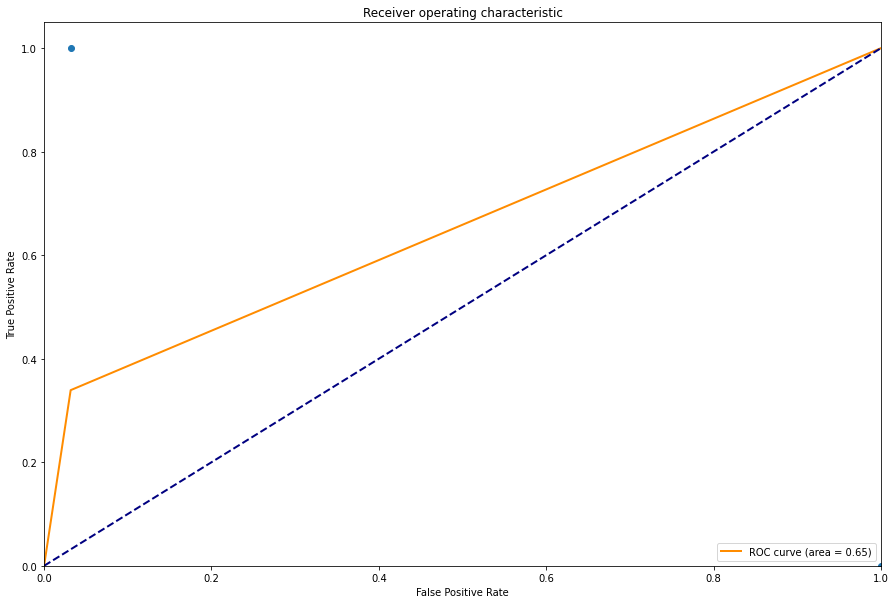

0.6537529163889919

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_test, predictions))

[1.22378259e-01 5.25664038e-02 1.79317327e-01 1.23157689e-02
 1.78849073e-02 2.49786378e-02 1.68920071e-02 1.92345400e-06
 2.71945667e-04 7.34659746e-03 3.26201899e-03 1.84890153e-02
 2.74522849e-03 1.42834051e-02 7.34802827e-03 4.50427410e-03
 1.97918583e-04 1.87819080e-02 1.56820372e-02 7.71064278e-03
 7.91107919e-03 4.26032676e-02 2.90900625e-02 1.05553020e-03
 4.83279858e-03 8.68600623e-03 1.25044652e-01 7.66314713e-03
 1.92797329e-02 1.26236222e-02 3.42207230e-03 7.67364413e-03
 4.54309806e-02 2.79060630e-02 1.14455450e-02 6.61744676e-03
 6.06680592e-03 1.81504959e-02 3.19920636e-02 1.01872465e-02
 6.43012399e-03 6.83239014e-03 6.17551175e-04 1.11618606e-02
 5.99751211e-03 1.43200443e-02]


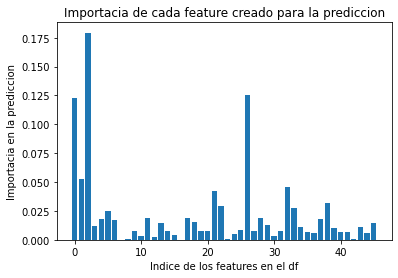

In [15]:
# Ver la importancia de cada feature para este algoritmo
model = ExtraTreesClassifier()
model.fit(X_train,y_train)

print(model.feature_importances_)

# Graficar importancia de cada uno
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title('Importacia de cada feature creado para la prediccion', )
plt.xlabel('Indice de los features en el df')
plt.ylabel('Importacia en la prediccion')
plt.show()

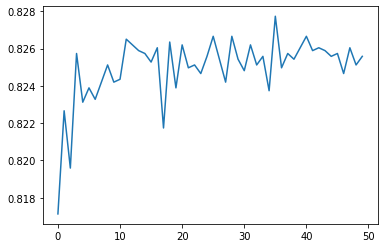

In [16]:
# Ver aporte de cada arbol
trees=range(50)
accuracy=np.zeros(50)

for idx in range(len(trees)):
    classifier=RandomForestClassifier(n_estimators=idx + 1)
    classifier=classifier.fit(X_train, y_train)
    predictions=classifier.predict(X_test)
    accuracy[idx]=accuracy_score(y_test, predictions)

plt.cla()
plt.plot(trees, accuracy)

# Prediccion sobre el archivo final

In [17]:
# data_test_final = getDataTestFinal()
data_test_final = pd.read_csv("/content/test.csv")
data_test_final.drop(columns = ["representatividad_poblacional"], inplace=True)
df.rename(columns={'ganancia_perdida_declarada_bolsa_argentina': 'ganancia_perdida_declarada_bolsa_argentina'}, inplace=True)
data_test_final.head()

,id,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,trabajo
0,1,11,Palermo,relacion_de_dependencia,25,2_anio,sin_matrimonio,0,hombre,40,judaismo,con_hijos,inspector
1,2,13,Palermo,relacion_de_dependencia,38,4_anio,matrimonio_civil,0,hombre,50,cristianismo,casado,sector_primario
2,3,16,Palermo,empleado_municipal,28,universidad_2_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,seguridad
3,4,14,Palermo,relacion_de_dependencia,44,5_anio,matrimonio_civil,7688,hombre,40,judaismo,casado,inspector
4,5,14,Palermo,NaN,18,5_anio,sin_matrimonio,0,mujer,30,cristianismo,con_hijos,NaN


In [20]:
df_test_final = pp.feature_engineering_xg_rf(data_test_final)
df_test_final.head()

,id,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
len(df_test_final.columns)

47

In [22]:
df_test_final.iloc[:, 1:47].head()

,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# Predecir
predictions_final=classifier.predict(df_test_final.iloc[:, 1:47])

predictions_final

array([0, 0, 1, ..., 1, 1, 1])

In [24]:
#Armo el submit
pd_predictions_final = pd.DataFrame(columns=["id", "tiene_alto_valor_adquisitivo"])

pd_predictions_final.id = df_test_final.id
pd_predictions_final.tiene_alto_valor_adquisitivo = predictions_final

pd_predictions_final.head()

,id,tiene_alto_valor_adquisitivo
0,1,0
1,2,0
2,3,1
3,4,1
4,5,0


In [25]:
out_df = pd_predictions_final[['id', 'tiene_alto_valor_adquisitivo']]
out_df.set_index('id', inplace=True)
out_df.head()

,tiene_alto_valor_adquisitivo
id,
1,0
2,0
3,1
4,1
5,0


In [26]:
out_df.to_csv('pd_predictions_final_random_forest.csv')